# PyTorch: Autoencoder convolucional Fashion-MNIST

## Refs.

* https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html

* https://github.com/zalandoresearch/fashion-mnist

* https://github.com/pranay414/Fashion-MNIST-Pytorch/blob/master/fashion_mnist.ipynb

## **Ejercicio 1)** Importando librerías

**0)** De ser necesario, **instale PyTorch** escribiendo

    !pip3 install torch torchvision torchaudio torchviz

**1)** Importe las librerías estandard de Python: `os`, `datetime`, `collections` y `pickle`.

**2)** Importe las siguientes librerías third party de Python: `matplotlib.pyplot`, `numpy`, `scipy`, `sklearn`, `pandas`, `dill` y `json`.

**3)** Importe las librerias necesarias de **PyTorch**: `torch` y `torchvision`.

**4)** Importe la librería: `google.colab`.

In [23]:
#import multiprocessing
#multiprocessing.set_start_method("spawn", force=True)


In [24]:
# 1.0)
#!pip3 install torch torchvision torchaudio torchviz
# ¡Instalación con Pip apuntando directamente a la versión 11.8!
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://download.pytorch.org/whl/cu118


In [25]:
# 1.1)
import os
import pickle
import datetime
from collections import defaultdict

In [26]:
# 1.2)
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import scipy as sp
import scipy.linalg as linalg
#import sklearn as skl
import pandas as pd
#import dill
import json

In [27]:
# 1.3
import torch
import torch.optim as optim
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torchvision import datasets
from torchvision import transforms
from torchvision.io import read_image
from torchvision.transforms import ToTensor, Lambda, Compose
#from torchviz import make_dot

In [28]:
# 1.4)
#import google.colab
#from google.colab import files

In [29]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
print(torch.version.cuda)

cuda
11.8


## **Ejercicio 2)**

Bajando y Jugando con el dataset **Fashion-MNIST**.

**1)** Baje y transforme los conjuntos de entrenamiento y testeo de FashionMNIST.

**2)** Grafique un mosaico de 3x3 imagenes de FashionMNIST, cada una titulada con su respectiva clasificación

In [30]:
# 2.1)
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])

# Download and load the training data
train_set_orig = datasets.FashionMNIST('MNIST_data/', download = True, train = True,  transform = transform)
valid_set_orig = datasets.FashionMNIST('MNIST_data/', download = True, train = False, transform = transform)


print(len(train_set_orig))  # 60000
print(len(valid_set_orig))        # 10000

60000
10000


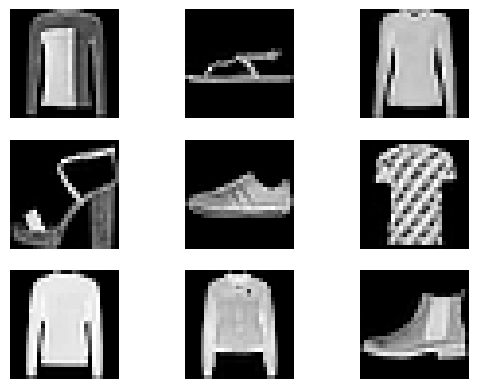

In [31]:
# 2.2)
figure = plt.figure()
cols,rows = 3,3
for i in range(1,cols*rows+1):
    j = torch.randint(len(train_set_orig),size=(1,)).item() # Los números aleatorios tambien se pueden generar desde pytorch. Util para trabajar en la GPU.
    image,label = train_set_orig[j]
    figure.add_subplot(rows,cols,i)
    plt.imshow(image.squeeze(), cmap="gray")  
    #plt.title(labels_names[label])
    plt.axis("off")

## Ejercicio 3) Creando un `DataSet` personalizado.

**1)** Con el fin de implementar un autoencoder, cree una clase derivada de la clase `DataSet` (llámela, por ejemplo `CustomDataset`) que, en vez de retornal el label asociado a cada imagen de `FashionMNIST`, retorne la imagen misma.

**2)** Utilice dicha clase para transformar los conjuntos de entrenamiento y testeo de `FashionMNIST` pensados para clasificación, a correspondientes conjuntos pensados para entrenar un autoencoder.
Para ello, defina una clase `CustomDataset` que deriva de la clase `Dataset`, cuyo método `__getitem__(self,i)` retorne el pair `input,output` donde tanto `input` cómo `output` son iguales a la $i$-ésima imagen del dataset.

In [32]:
# 3.1)
# Creamos una subclase de la clase Dataset que nos sirva para generar lotes de ejemplos que puedan usarse para entrenar un autoencoder
class CustomDataset(Dataset):
    def __init__(self,dataset):
        self.dataset=dataset
    # Redefinimos el método .__len__()
    def __len__(self):
        return len(self.dataset)
    # Redefinimos el método .__getitem__()
    def __getitem__(self,i):
        image,label=self.dataset[i]
        input  = image
        output = image #torch.flatten(image) # retornamos la imagen como salida
        return input,output

In [33]:
# 3.2)
# Convertimos FashionMNIST Dataset a CustomDataset
train_set = CustomDataset(train_set_orig)
valid_set = CustomDataset(valid_set_orig)

## Ejercicio 4) Red Neuronal Autoencoder Convolucional

**1)** Defina y cree una red neuronal *autoencoder convolucional* constituida por las siguientes capas:


1. Capa convolucional 2D (encoder) compuesta por:

  * Una capa `Conv2d` (ver [documentación](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)) que mapea una entrada con $1$ canal y dimensiones $(28,28)$ a una salida con $16$ canales y dimensiones $(26,26)$.
    Utilice un kernel de dimensiones $(3,3)$ y el resto de los parámetros en sus valores por defecto.
  * Una capa `ReLU`.
  * Una capa `MaxPool2d` con un kernel de dimensiones $(2,2)$, de modo que la salida resultante tenga dimensiones $(16,13,13)$.
  * Una capa `Dropout` con probabilidad $p$.

2. Capa lineal (cuello de botella o “bottleneck”) compuesta por:

  * Una capa `Flatten` que transforma una entrada de dimensiones $(16,13,13)$ en un vector de dimensión $16\times 13\times 13 = 2704$.
  * Una capa `Linear` que mapea el vector de dimensión $2704$ a un vector de dimensión $n$ (donde $n$ es un número mucho menor, por ejemplo $n=128$, representando la *codificación comprimida* o *latente*).
  * Una capa `ReLU`.
  * Una capa `Linear` que mapea de nuevo el vector de dimensión $n$ al espacio original de dimensión $2704$.
  * Una capa `ReLU`.

3. Capa convolucional 2D transpuesta (decoder) compuesta por:

  * Una capa `Unflatten` que mapea el vector de dimensión $2704$ a una representación de $16$ canales con dimensiones $(13,13)$.
  * Una capa `ConvTranspose2d` (ver [documentación](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html)) que mapea $16$ canales de dimensiones $(13,13)$ a $1$ canal de dimensiones $(28,28)$. Utilice un kernel de dimensiones $(6,6)$, un stride de $(2,2)$, y un padding de $(1,1)$.
  * Una capa `Sigmoid`, para asegurar que las salidas se encuentren en el rango $[0,1]$ (asumiendo que las imágenes originales también fueron normalizadas en dicho rango).

**2)** Grafique, a modo de comparación, algunas imágenes de entrada y sus correspondientes reconstrucciones obtenidas con el modelo **sin entrenar** y con una probabilidad de *dropout* $p=0.2$.

In [34]:
# 4.1)
class NeuralNetwork(nn.Module):
    def __init__(self,n,p=0.2):
        super(NeuralNetwork,self).__init__()
        #capa0 : convolucional 2D
        self.conv0 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3)  #De 28x28x1 a 26x26x16. Son 16 filtros convolucionales. Cada filtro extrae una característica diferente. 
        #Si aca usamos padding=1, la salida sería 28x28x16 pues mantenemos las dimensiones espaciales debido a que el padding lo que hace es agregar una capa de ceros alrededor de la imagen.
        # Y si aca usamos stride=2, la salida sería 13x13x16, pues reducimos las dimensiones espaciales a la mitad. Ya que stride=2 significa que el filtro se mueve de a 2 pixeles en cada paso con lo cual se reduce la resolución espacial.
        # Si el tamaño del kernel aumentara a 5, la salida sería 24x24x16, pues el tamaño del kernel afecta las dimensiones espaciales de la salida.
        self.relu = nn.ReLU() 
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) #Reducción de dimensionalidad: de 26x26 a 13x13, canales siguen siendo 16. 
        self.dropout = nn.Dropout(p) 

        #capa 1 : bottleneck
        self.flatten = nn.Flatten()#start_dim=(16,13,13)) #De 16x13x13 a 2704
        self.fc2_0 = nn.Linear(16*13*13,n)  #de 2704 a n, codificación 
        #relu
        self.fc2_1 = nn.Linear(n,16*13*13)  #de n a 2704, decodificación
        #relu

        #capa 2
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(16,13,13)) #de 2704 a 16x13x13
        self.convtr2 = nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=6,stride= 2, padding=1)  #de 16x13x13 a 28x28x1, son 28 porque usamos stride=2, que duplica las dimensiones espaciales.
        self.sigmoid = nn.Sigmoid() 
    
    def forward(self,x):
        #capa0
        x = self.conv0(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.dropout(x)
        #capa1
        x = self.flatten(x)
        x = self.fc2_0(x)
        x = self.relu(x)
        x = self.fc2_1(x)
        x = self.relu(x)
        #capa2
        x = self.unflatten(x)
        x = self.convtr2(x)
        x = self.sigmoid(x)
                    
        return x

mi_red = NeuralNetwork(128,p=0.2)

## Ejercicio 5) Entrenando el modelo

**1)** Implemente, en una función, un loop de entrenamiento que recorra los batchs (lotes).

**2)** Implemente, en una función, un loop de prueba o validación que recorra los batchs.

**3)** Inicialize dos `DataLoader`s llamados `train_loader` y `valid_loader` que estén definidos sobre  el `train_set` (conjunto de entranmiento) y el `valid_set` (conjunto de prueba) de Fashion-MNIST, respectivamente, y que usen batchs de 100 ejemplos.

**4)** Cree una función de pérdida usando el **Error Cuadrático Medio**.

**5)** Cree un optimizador con un learning rate igual a $10^{-3}$.
Pruebe con **ADAM**.

**6)** Cree una instancia del modelo con dropout $p=0.2$.

**7)** Especifique en que dispositivo (`device`) va a trabajar: en una **CPU** o en una **GPU**.

**8)** Implemente un loop que itere sobre épocas de entrenamiento y validación, y que guarde en listas correspondientes los siguientes valores del **ECM**:
*  promedios (incorrectos) sobre el conjunto de entrenamiento, calculado **durante** el proceso de entrenamiento sobre la época.
*  promedios (correctos) sobre el conjunto de entrenamiento, calculados **posteriormente** al proceso de entrenamiento sobre la época.
*  promedios (correctos) sobre el conjunto de validación, calculados **posteriormente** al proceso de entrenamiento sobre la época.

**IMPORTANTE:** No olvide copiar los batchs al dispositivo de trabajo.

**9)** Entrene y valide el modelo.

**10)** Use las listas del inciso **8)** para graficar en función de las **épocas de entrenamiento** el **ECM** de **entrenamiento** y **validación**, respectivamente.
Discuta y comente, cual es el número óptimo de épocas de entrenamiento?

**11)** Grafique, comparativamente, algunas de las imagenes a predecir vs las imagenes predichas por el modelo entrenado.

**12)** Repita para otras elecciones de los hiperparámetros tales como, el optimizador (podría ser el **SGD**), el **learning-rate**, el tamaño de los **batchs**, el **dropout**, **capas convolucionales** y **convolucionales traspuestas** de otros tamaños.
En particular, pruebe eliminando, adecuadamente, la **capa lineal**.
Que valores de estos hiperparámetros considera los más convenientes? Porqué?

In [35]:
# 5.1)
def train_loop(dataloader,model,loss_fn,optimizer):
    model.train()
    num_samples = len(dataloader.dataset)
    num_batches = len(dataloader)
    sum_loss = 0
    sum_correct = 0
    sum_samples = 0
    for batch, (X,y) in enumerate(dataloader): 
        #enumerate devuelve una lista de tuplas (indice, valor), entonces al hacer
        # for batch, (X,y) desestructura la tupla en indice(batch) y valor(X(imagenes), y(etiquetas))

        # Copiamos las salidas y entradas al dispositivo de trabajo
        X, y = X.to(device), y.to(device)

        # Forward pass
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Statistics
        batch_size = len(X)
        # calculamos la perdida promedio del batch y lo agregamos a una suma correspondiente
        sum_loss += loss.item() * batch_size # loss = suma de perdidas en el batch / batch_size => loss.item() * batch_size = suma de perdidas en el batch

        # En este caso no tiene sentido calcular la cantidad de predicciones correctas porque es un autoencoder y no una tarea de clasificación
        #sum_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        # actualizamos la cantidad de muestras procesadas
        sum_samples += batch_size

        #if batch % (num_batches / 10) == 0: # evaluamos en el 10% de los batches, para no saturar
        avrg_loss = sum_loss / sum_samples
        # precision = sum_correct / sum_samples
        print(f"  Batch {batch:>5d}/{num_batches:>5d} - avrg_Loss: {avrg_loss:>7f}  processed_samples: {100*sum_samples/num_samples:>5f}%") #5d ?
        
    assert num_samples == sum_samples, "Error en el conteo de muestras procesadas"
    avrg_loss = sum_loss / sum_samples
    #precision = sum_correct / sum_samples

    return avrg_loss #, precision

In [36]:
#5.2)
def valid_loop(dataloader,model,loss_fn):
    model.eval()
    num_samples = len(dataloader.dataset)
    num_batches = len(dataloader)
    sum_loss = 0
    sum_correct = 0
    sum_samples = 0
    with torch.no_grad(): # es un context manager que desactiva el cálculo del gradiente momentáneamente, 
        #para ahorrar memoria y mejorar el rendimiento durante la evaluación del modelo.

        for X,y in dataloader: #iteramos sobre los batches del dataloader, esto es posible ya que si bien dataloader no es una lista,
            # implementa el protocolo iterable de python, por lo que se puede usar en un for, y en cada iteracion genera un batch nuevo

            # Copiamos las salidas y entradas al dispositivo de trabajo
            X, y = X.to(device), y.to(device)
            batch_size = len(X)
            sum_samples += batch_size

            pred = model(X)
            loss = loss_fn(pred, y)

            sum_loss += loss.item() * batch_size
            #sum_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    
    assert num_samples == sum_samples, "Error en el conteo de muestras procesadas"
    avrg_loss = sum_loss / sum_samples
    #precision = sum_correct / sum_samples
    print(f"@eval_loop_avg_loss={avrg_loss:>8f}") #, precision={100*precision:0.1f}%")

    return avrg_loss #, precision

In [37]:
# 5.3)
batch_size = 100
train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle = True,num_workers=8, pin_memory=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size = batch_size, shuffle = True,num_workers=8, pin_memory=True)

In [38]:
#5.4)
#Creamos una instancia de una funcion de perdida, en este caso error cuadratico medio
loss_fn = nn.MSELoss()

In [39]:
#5.6)
#valores segun ej4
n = 128
p = 0.2
model = NeuralNetwork(n, p = p)

#5.5)
#definimos el optimizador, en este caso SGD
learning_rate = 1e-3
#optimizer = optim.SGD(model.parameters(), lr=learning_rate)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [40]:
#5.7)
#definimos el dispositivo de trabajo, una cpu o una gpu si esta disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#pasamos el modelo al dispositivo
model = model.to(device)
print(device)

cuda


In [41]:
#5.8) y 5.9)
num_epochs = 30
list_train_avg_loss_incorrecta = []
list_train_avg_loss = []
list_valid_avg_loss = []
list_train_precisiom_incorrecta = []
list_train_precision = []
list_valid_precision = []
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}:\n-------------------------------")
    train_avg_loss_incorrecta = train_loop(train_loader, model, loss_fn, optimizer)
    train_avg_loss = valid_loop(train_loader, model, loss_fn)
    valid_avg_loss = valid_loop(valid_loader, model, loss_fn)

    list_train_avg_loss_incorrecta.append(train_avg_loss_incorrecta)

    list_train_avg_loss.append(train_avg_loss)
    list_valid_avg_loss.append(valid_avg_loss)


print("Training complete.")

Epoch 1/30:
-------------------------------
  Batch     0/  600 - avrg_Loss: 1.392717  processed_samples: 0.166667%
  Batch     1/  600 - avrg_Loss: 1.379994  processed_samples: 0.333333%
  Batch     2/  600 - avrg_Loss: 1.367504  processed_samples: 0.500000%
  Batch     3/  600 - avrg_Loss: 1.327966  processed_samples: 0.666667%
  Batch     4/  600 - avrg_Loss: 1.289367  processed_samples: 0.833333%
  Batch     5/  600 - avrg_Loss: 1.256989  processed_samples: 1.000000%
  Batch     6/  600 - avrg_Loss: 1.222493  processed_samples: 1.166667%
  Batch     7/  600 - avrg_Loss: 1.189563  processed_samples: 1.333333%
  Batch     8/  600 - avrg_Loss: 1.153316  processed_samples: 1.500000%
  Batch     9/  600 - avrg_Loss: 1.119422  processed_samples: 1.666667%
  Batch    10/  600 - avrg_Loss: 1.090040  processed_samples: 1.833333%
  Batch    11/  600 - avrg_Loss: 1.062676  processed_samples: 2.000000%
  Batch    12/  600 - avrg_Loss: 1.037789  processed_samples: 2.166667%
  Batch    13/  600 

In [45]:

from datetime import datetime
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"model_{timestamp}.pth"
torch.save(model.state_dict(), filename)
print("Guardado como:", filename)
'''
#cargamos el modelo guardado
model = NeuralNetwork(128, 0.2)
nombre = "./TP_FINAL/caso02/caso02.pth"
model.load_state_dict(torch.load(nombre))
model = model.to(device)
model.eval()'''


Guardado como: model_20251209_000451.pth


'\n#cargamos el modelo guardado\nmodel = NeuralNetwork(128, 0.2)\nnombre = "./TP_FINAL/caso02/caso02.pth"\nmodel.load_state_dict(torch.load(nombre))\nmodel = model.to(device)\nmodel.eval()'

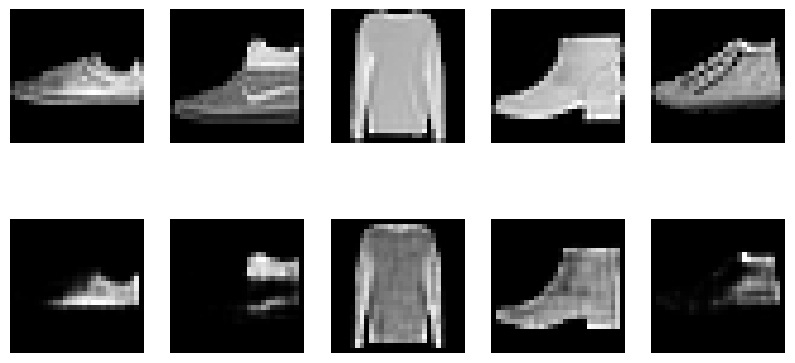

In [43]:
# probando la red entrenada con un ejemplito
numero_img = 0
imgs_before = []
imgs_after = []
for i in range(5):  # Cambiamos el rango para probar varias imágenes
    dataiter = iter(valid_loader)
    images, labels = next(dataiter)

    img = images[numero_img]  # Agregar dimensión de batch
    imgs_before.append(img.cpu().squeeze())
    # Pasar la imagen por el modelo
    with torch.no_grad():
        img = img.to(device)
        output = model(img.unsqueeze(0))  # Agregar dimensión de batch
        imgs_after.append(output.cpu().squeeze())

#comparacion imagen original vs reconstruida
#imagen:
figure = plt.figure()
#ajustamos el tamaño de la figura
figure.set_size_inches(10, 5)  # Ajusta el tamaño de la figura
cols,rows = 5,2
#graficamos arriba las 5 figuras originales y abajo las 5 reconstruidas
for i in range(len(imgs_before)):
    figure.add_subplot(rows,cols,i+1)
    plt.imshow(imgs_before[i], cmap='gray')
    plt.axis("off")
for i in range(len(imgs_after)):
    figure.add_subplot(rows,cols,i+1+5)  # Agregamos las imágenes reconstruidas en la segunda fila
    plt.imshow(imgs_after[i], cmap='gray')
    plt.axis("off")
plt.show()

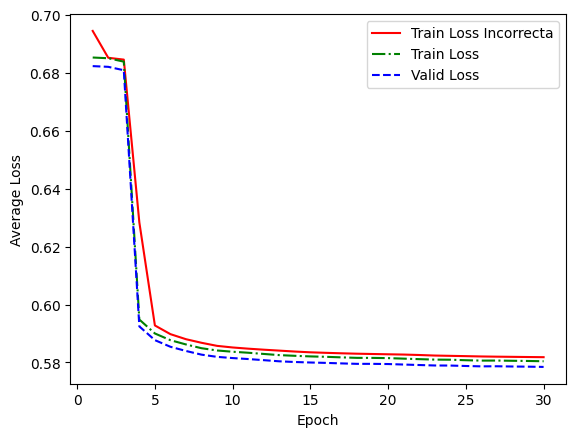

'\nplt.xlabel("Epoch")\nplt.ylabel("Precision")\nplt.plot(range(1,len(list_train_precisiom_incorrecta)+1),  list_train_precisiom_incorrecta, label="Train Precision Incorrecta",linestyle=\'-\', c=\'red\')\nplt.plot(range(1,len(list_train_precision)+1),  list_train_precision, label="Train Precision",linestyle=\'-\', c=\'green\')\nplt.plot(range(1,len(list_valid_precision)+1), list_valid_precision, label="Valid Precision",linestyle=\'--\', c=\'blue\')\nplt.legend()\n#plt.title("")\nplt.show() '

In [44]:
#5.10)
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.plot(range(1,len(list_train_avg_loss_incorrecta)+1), list_train_avg_loss_incorrecta, label="Train Loss Incorrecta",linestyle='-', c='red')
plt.plot(range(1,len(list_train_avg_loss)+1), list_train_avg_loss, label="Train Loss",linestyle='-.', c='green')
plt.plot(range(1,len(list_valid_avg_loss)+1), list_valid_avg_loss, label="Valid Loss",linestyle='--', c='blue')
plt.legend()
#plt.title("")
plt.show()
'''
plt.xlabel("Epoch")
plt.ylabel("Precision")
plt.plot(range(1,len(list_train_precisiom_incorrecta)+1),  list_train_precisiom_incorrecta, label="Train Precision Incorrecta",linestyle='-', c='red')
plt.plot(range(1,len(list_train_precision)+1),  list_train_precision, label="Train Precision",linestyle='-', c='green')
plt.plot(range(1,len(list_valid_precision)+1), list_valid_precision, label="Valid Precision",linestyle='--', c='blue')
plt.legend()
#plt.title("")
plt.show() '''

